# Lecture 14
_____________


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import cvxpy as cvx
import seaborn as sns
sns.set_style('whitegrid')

## _Pareto sorting_

Identifying the pareto front from a set of possible points. Assumes minimization

$a$ dominates $b$ if it is <= in all objectives and < in at least one

In [2]:
def dominates(a, b): # function that checks if a dominates b
    return (np.all(a <= b) and np.any(a < b)) # minimization (<)

The function `pareto_sort` accepts a matrix of points, returns a matrix of only the nondominated ones. It is not the most efficient method to do this.

`keep` is an array of booleans used to index the matrix at the end

In [3]:
def pareto_sort(P):
    N = len(P)
    keep = np.ones(N, dtype=bool) # all True to start
    
    for i in range(N):
        for j in range(i+1,N):
            if keep[j] and dominates(P[i,:], P[j,:]):
                keep[j] = False
            
            elif keep[i] and dominates(P[j,:], P[i,:]):
                keep[i] = False
    
    return P[keep,:] # only keeping the nondominated points

A matrix of data points for a hypothetical 2-objective problem

In [4]:
circle_points = np.loadtxt('data/circle-points.csv', delimiter=',')
pareto = pareto_sort(circle_points)

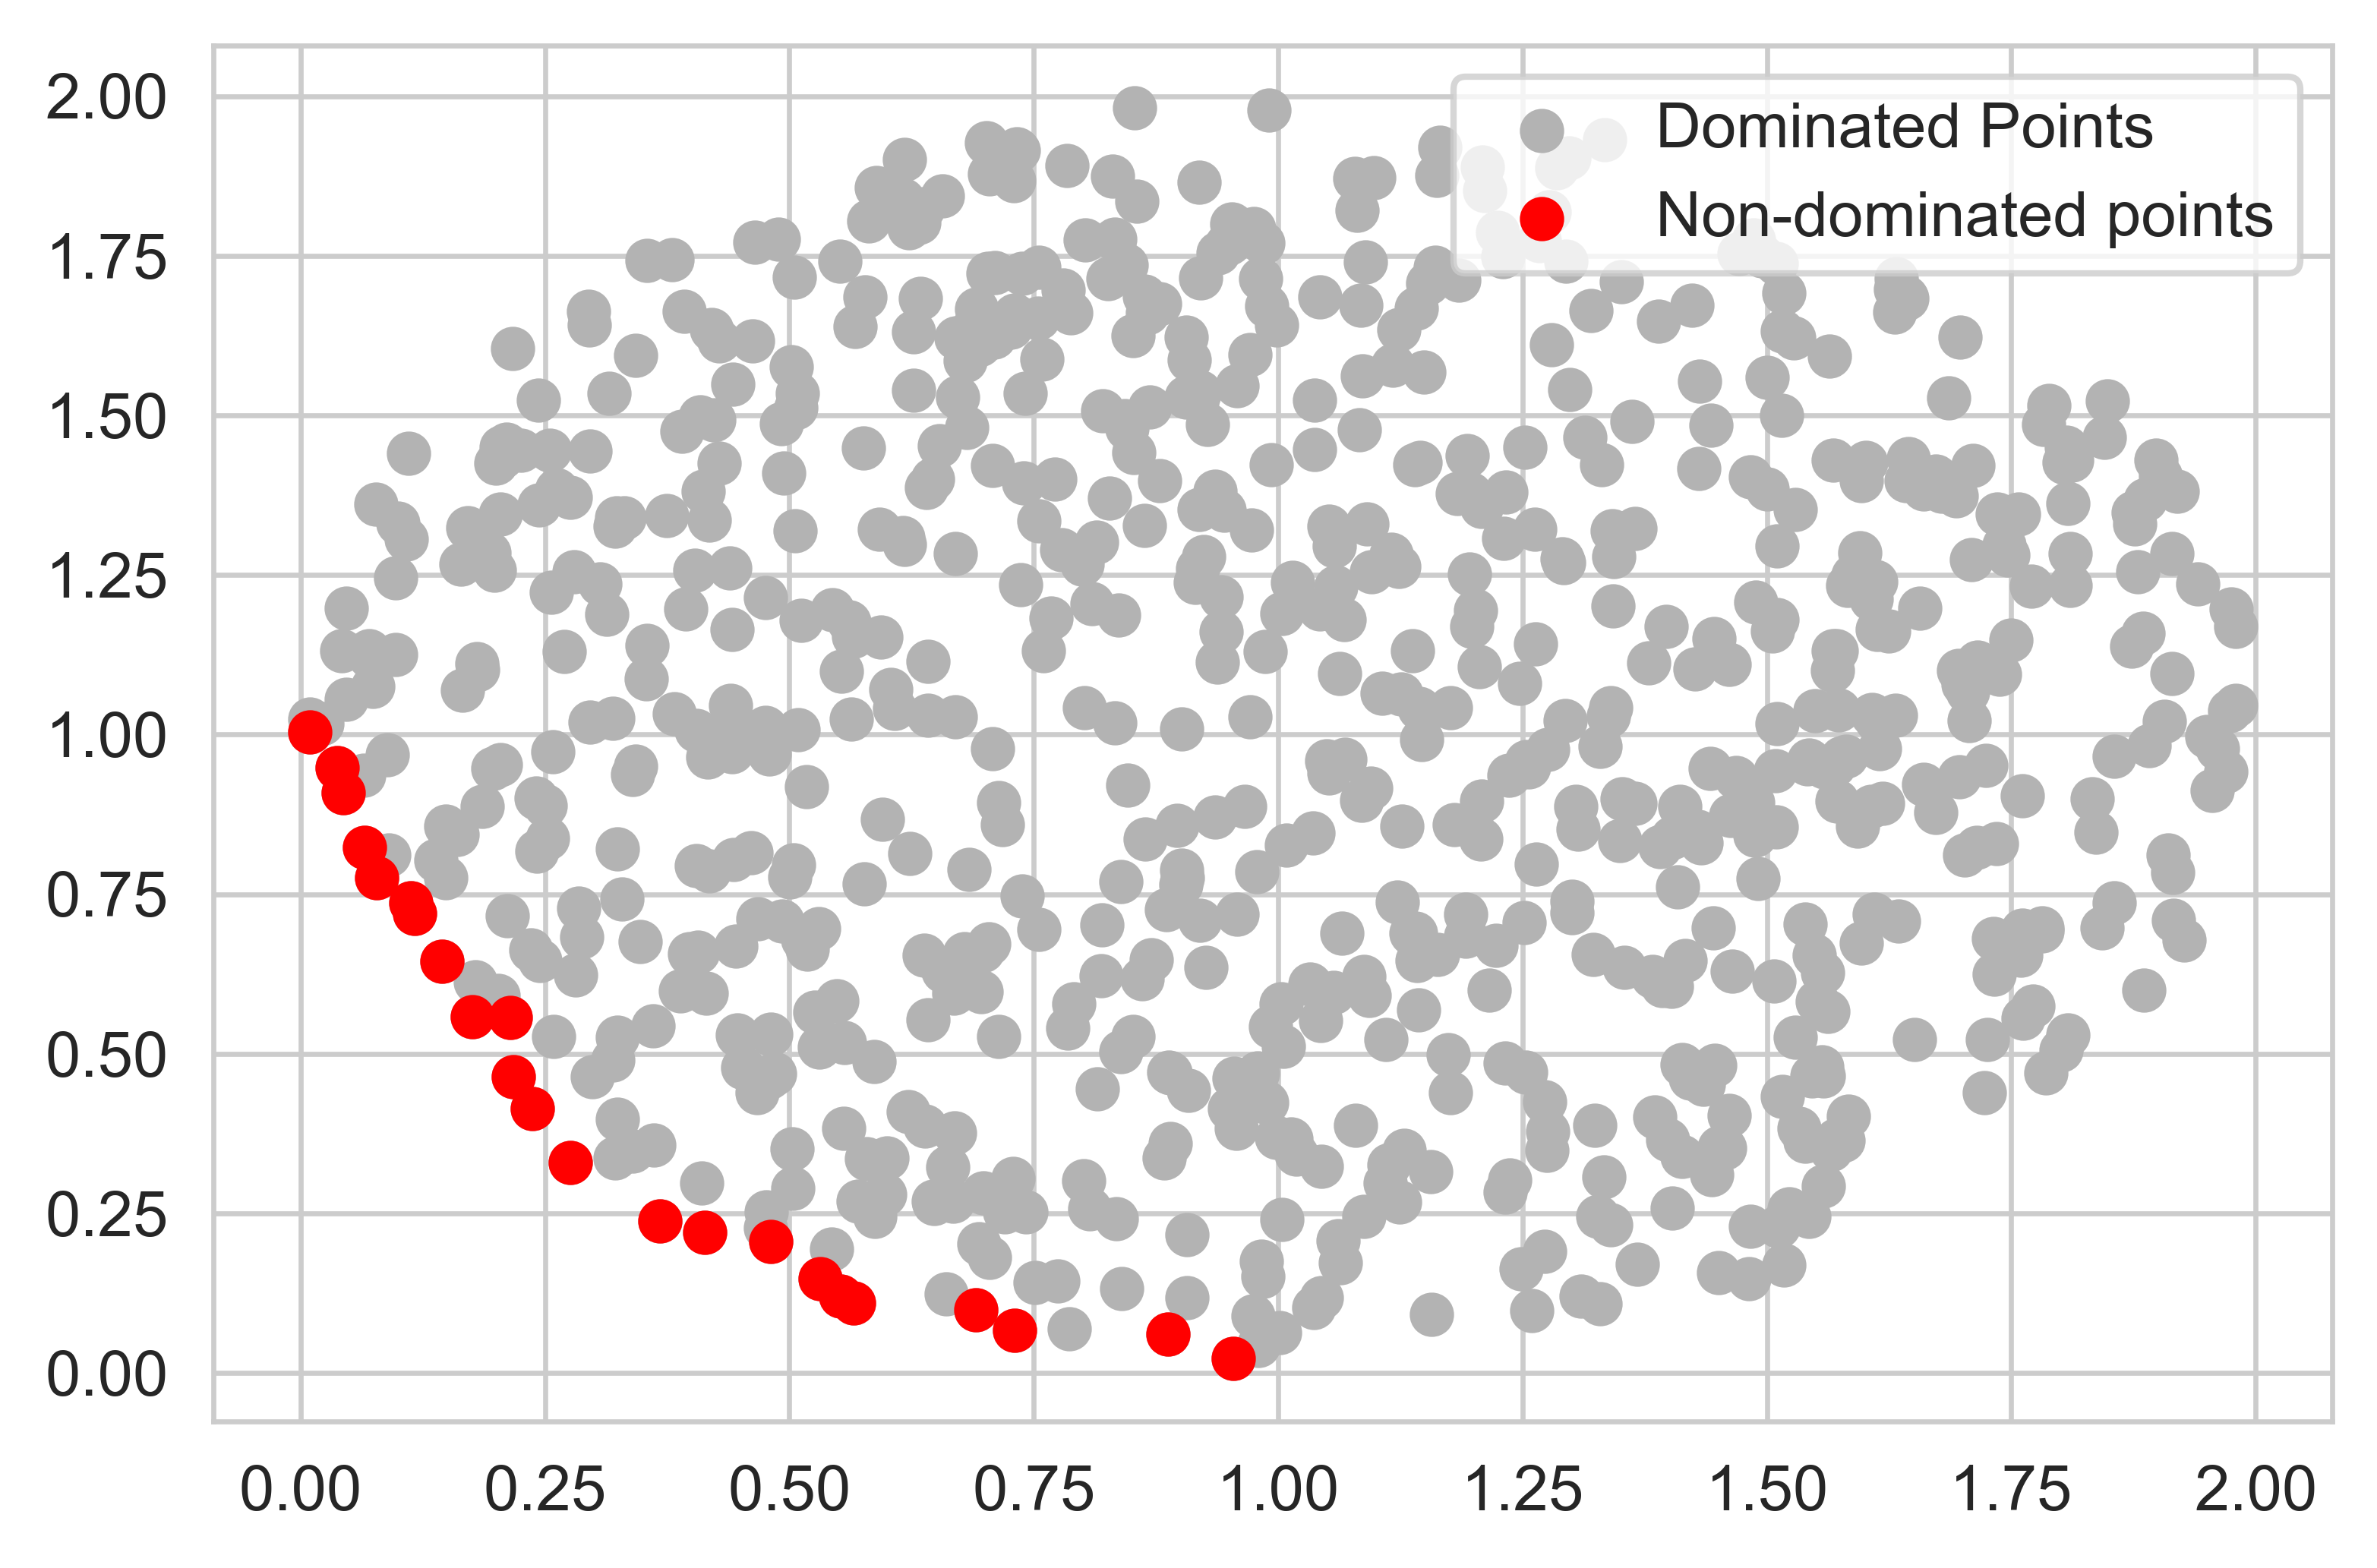

In [5]:
plt.scatter(circle_points[:,0],circle_points[:,1], c='0.7')
plt.scatter(pareto[:,0], pareto[:,1], c='red')
plt.legend(['Dominated Points', 'Non-dominated points'])
plt.show()

----------

## _Multiobjective function - example_

Two-objective problem, no constraints

In [6]:
from scipy import optimize

In [7]:
def f1(x):
    return x[0]**4 - 10*x[0]**2+x[0]*x[1] + x[1]**4 -(x[0]**2)*(x[1]**2)

def f2(x):
    return x[1]**4 - (x[0]**2)*(x[1]**2) + x[0]**4 + x[0]*x[1]

x_keep = []
f_keep = []
dw = 0.05 # how much to change weights by

for w in np.arange(0,1+dw,dw):
    # redefine the single-objective function with new weights
    # yea you can do this, maybe don't make a habit of it though
    def objfun(x):
        return w*f1(x) + (1-w)*f2(x)
    
    sol = optimize.minimize(objfun, x0 = [1,-1])
    x_keep.append(sol.x)
    f_keep.append([f1(sol.x), f2(sol.x)]) # re-run separate objective functions

Just plotting below here...

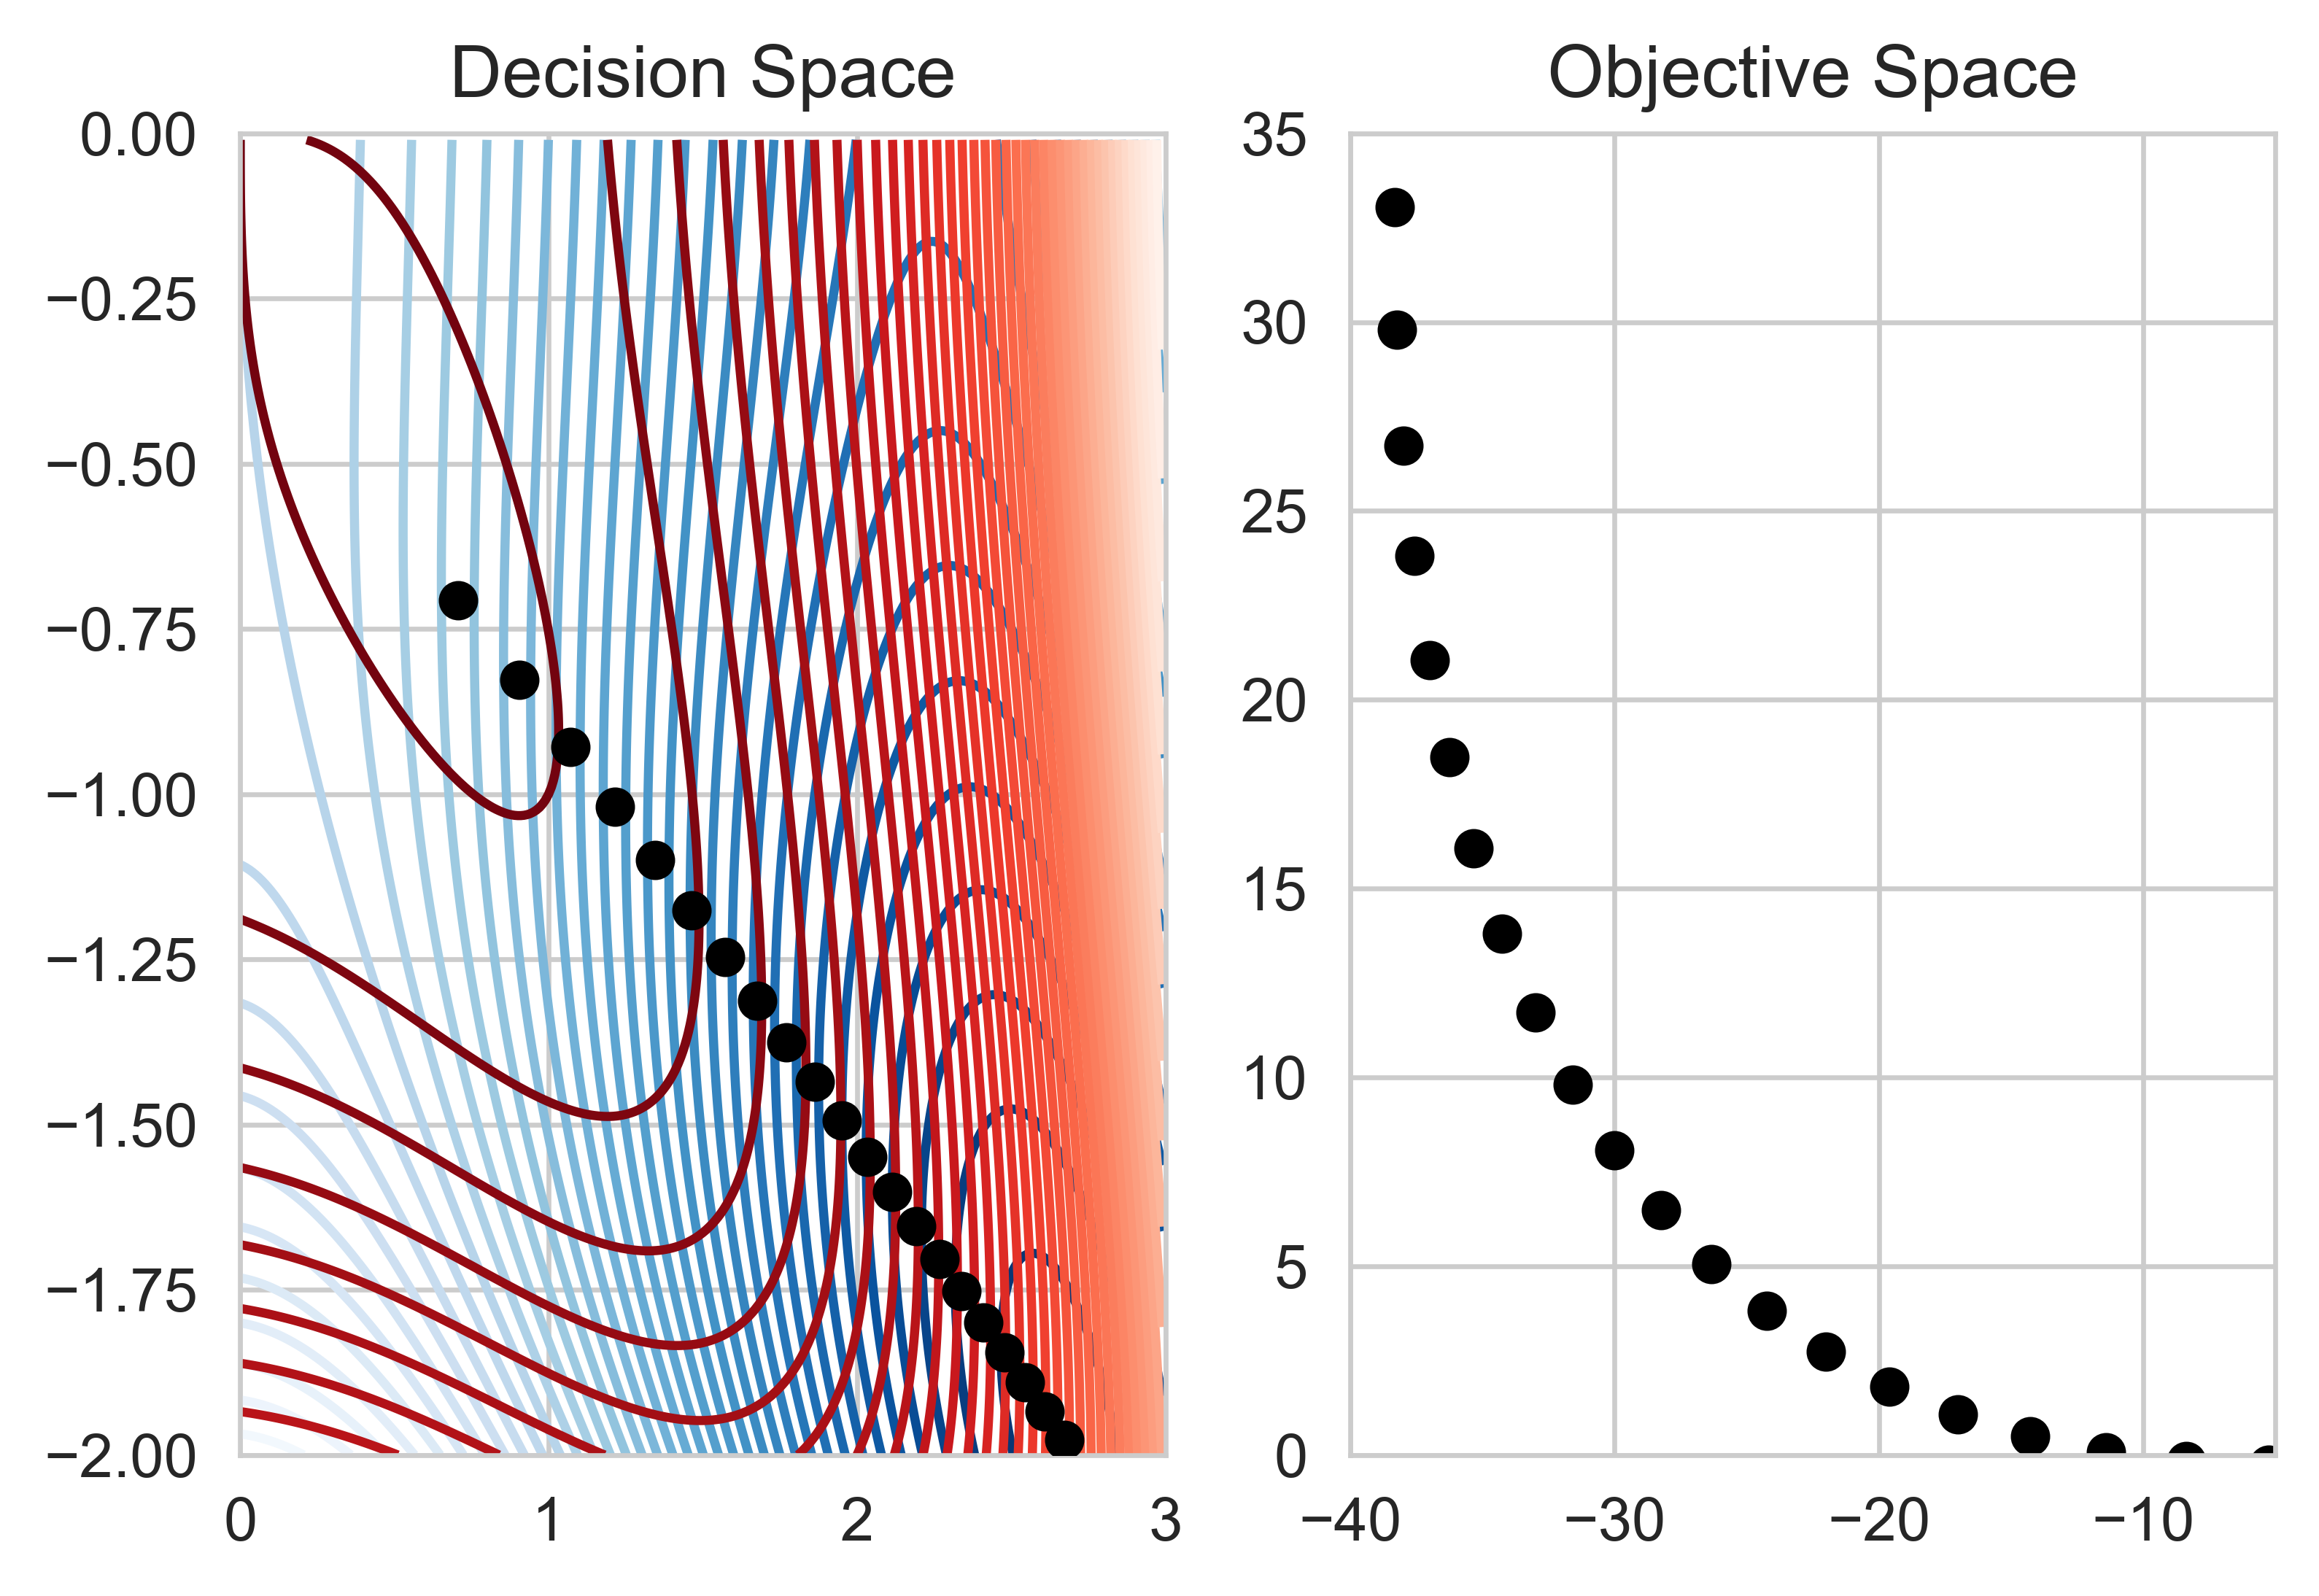

In [8]:
x_keep = np.array(x_keep)
f_keep = np.array(f_keep)

plt.subplot(1,2,1)

X1,X2 = np.meshgrid(np.arange(0,3,0.01), np.arange(-2,0,0.01))

plt.contour(X1,X2,f1([X1,X2]),50,cmap=plt.cm.Blues_r)
plt.contour(X1,X2,f2([X1,X2]),50,cmap=plt.cm.Reds_r)
plt.scatter(x_keep[:,0], x_keep[:,1], zorder=5, color='k', s=30)
plt.ylim([-2,0])
plt.xlim([0,3])
plt.title('Decision Space')

plt.subplot(1,2,2)
plt.scatter(f_keep[:,0], f_keep[:,1], color='k', s=30)
plt.xlim([-40,-5])
plt.ylim([0,35])
plt.title('Objective Space')

plt.show()

----------

## _Reservoir control - multiobjective optimization_

Multi-objective reservoir control (NLP problem): tradeoff between shortage cost and hydrologic alteration

In [9]:
Q = np.loadtxt('data/FOL-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1])
T = len(Q)
K = 975 # reservoir capacity
d = 150*np.ones(T) # target demand (TAF/day)
dw = 0.1

results = [] # will become the pareto front

__Weighted sum method__

0
1
2
3
4
5
6
7
8
9
10


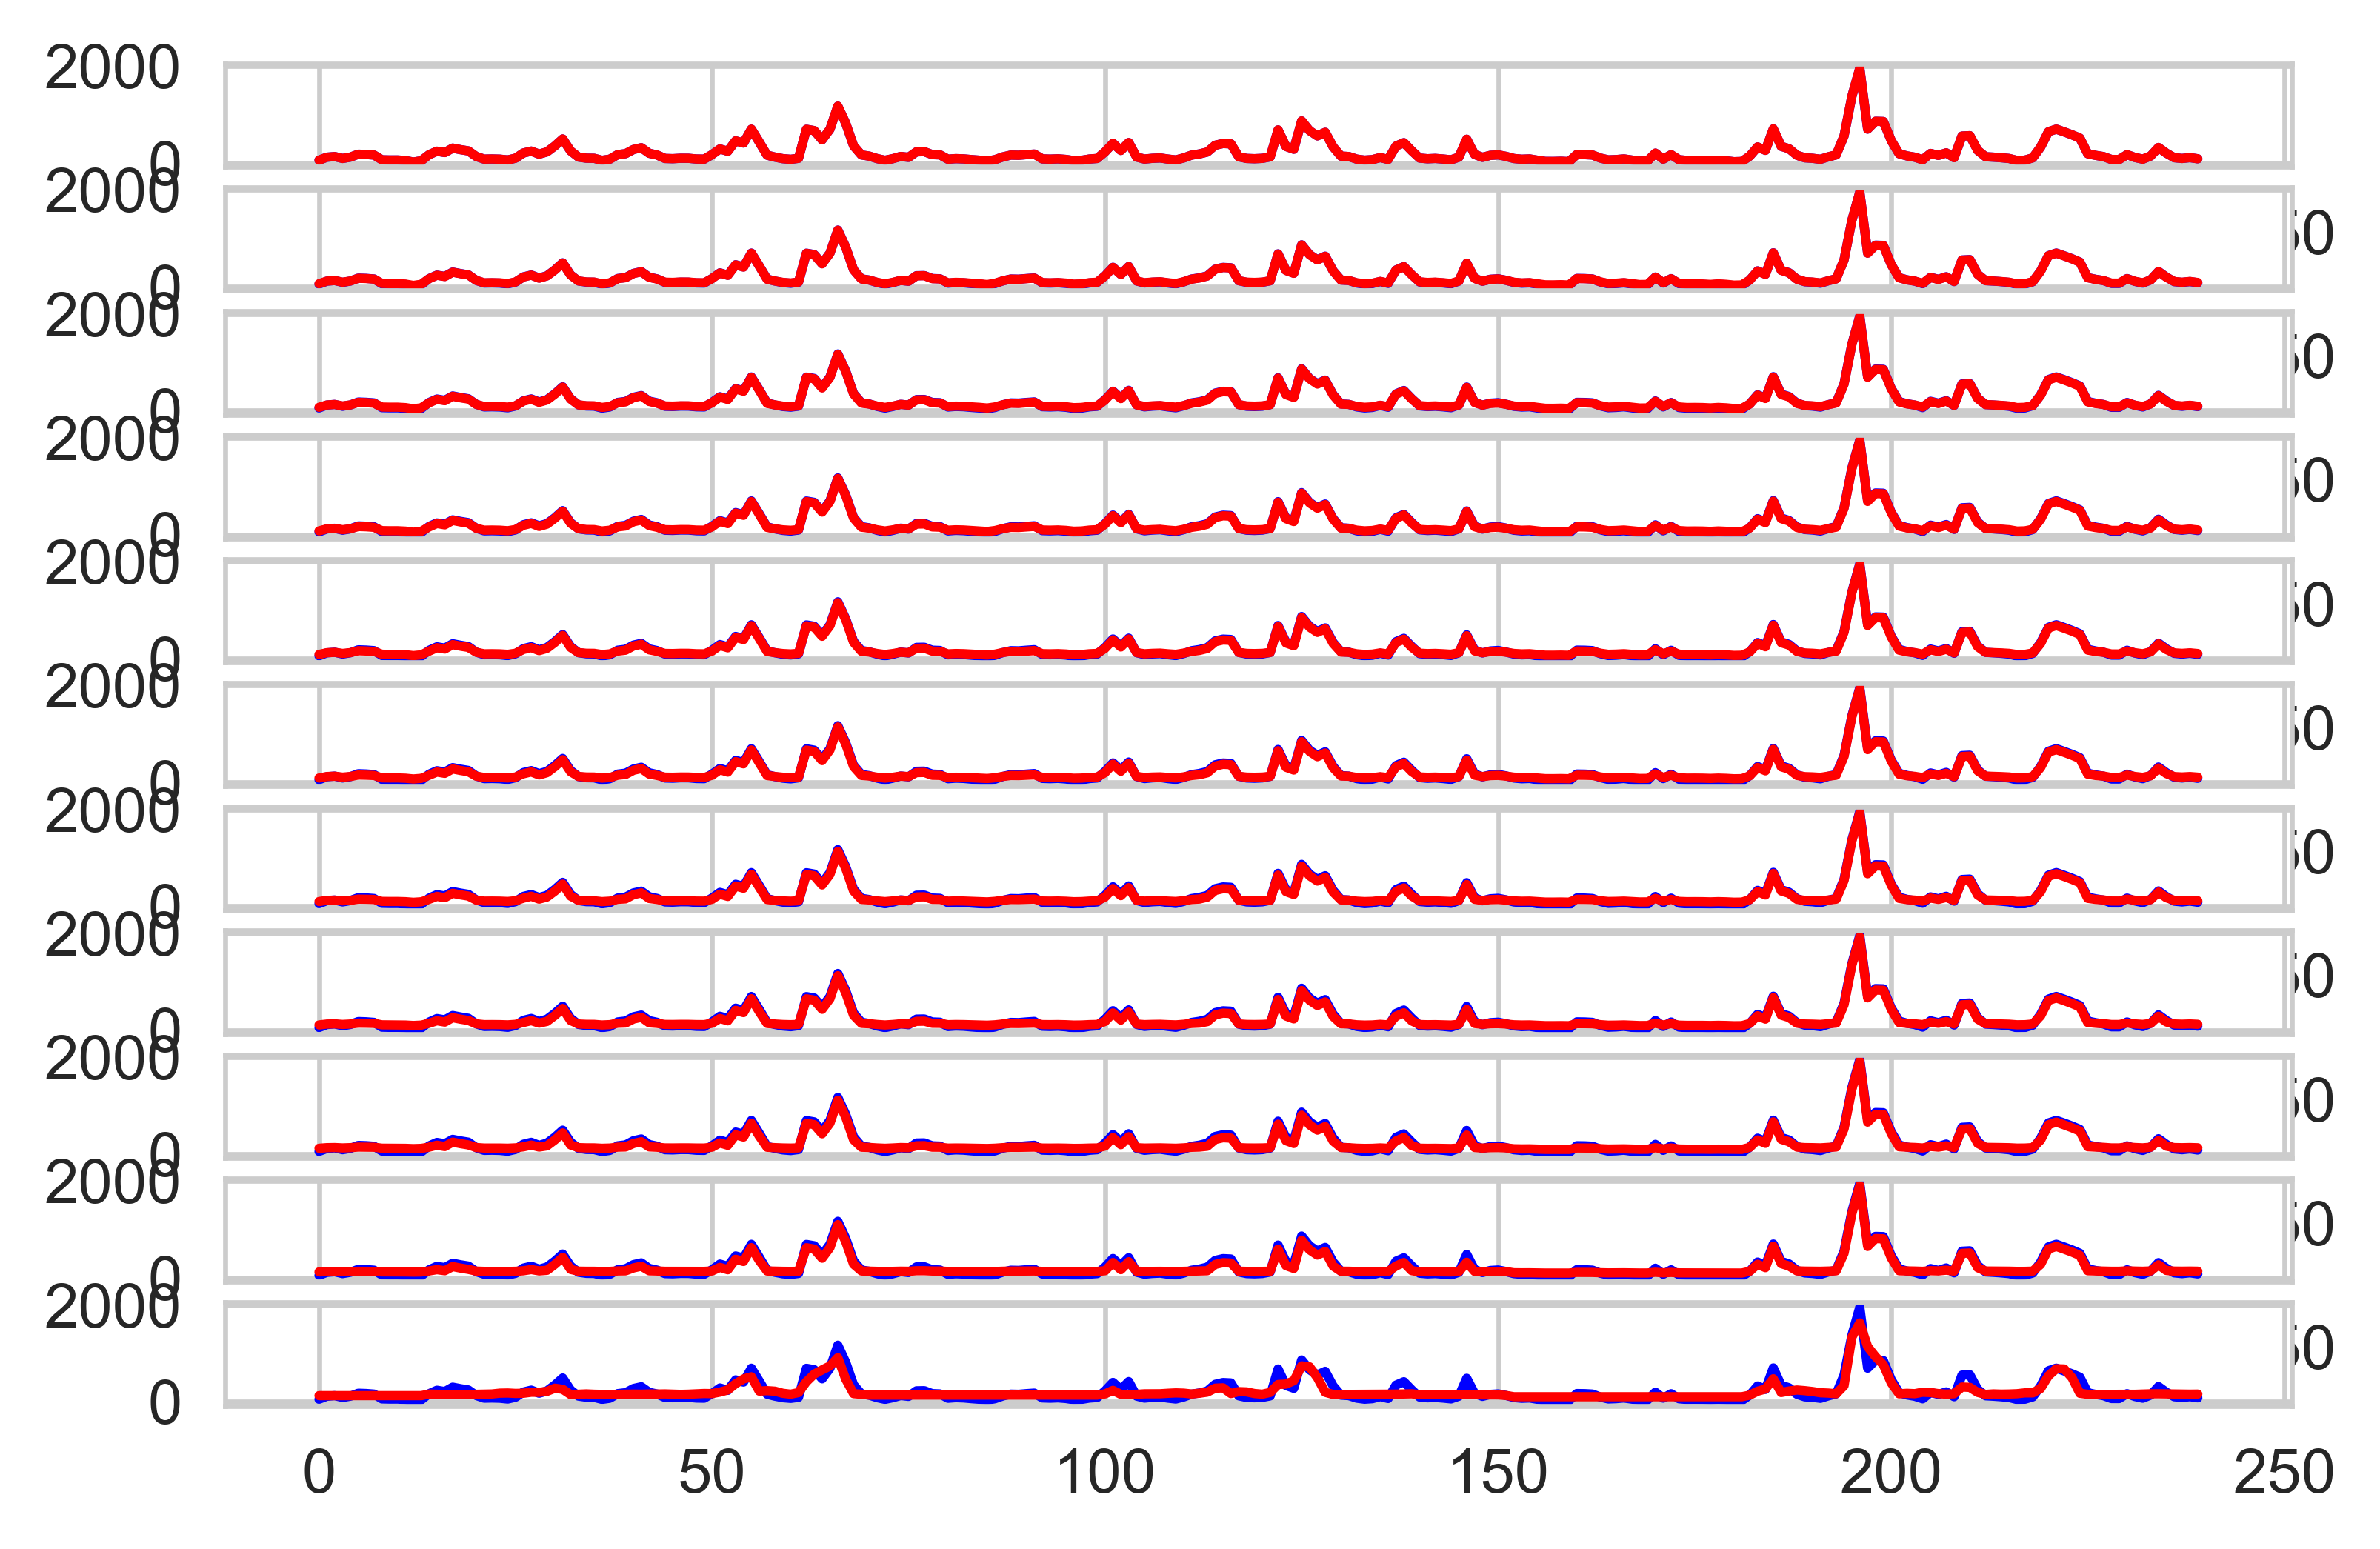

In [15]:
for i,w in enumerate(np.arange(0,1+dw,dw)):
    # i is the loop counter, w is the weight
    
    x = cvx.Variable(T+1)
    u = cvx.Variable(T)
    cost = cvx.sum((cvx.pos(d - u))**2)
    alteration = cvx.sum((u-Q)**2)
    
    obj = cvx.Minimize(w*cost + (1-w)*alteration) # sum squared deficit (vector form)
    
    # constraints (define separately, then concatenate the lists)
    c_mass_balance = [x[1:] == x[:-1] - u + Q] # state transition
    c_release = [u >= 0] # release lower/upper bounds
    c_storage = [x >= 0, x <= K] # storage lower/upper bounds
    c_init_final = [x[0] == 500, x[T] >= 200]
    constraints = c_mass_balance + c_release + c_storage + c_init_final
    
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    results.append([cost.value, alteration.value])
    
    plt.subplot(11,1,i+1)
    plt.plot(Q, color='blue')
    plt.plot(u.value, color='red')
    # plt.ylabel('Flow (TAF/m)')
    # plt.legend(['Inflow', 'Outflow'])
    print(i)

plt.show()

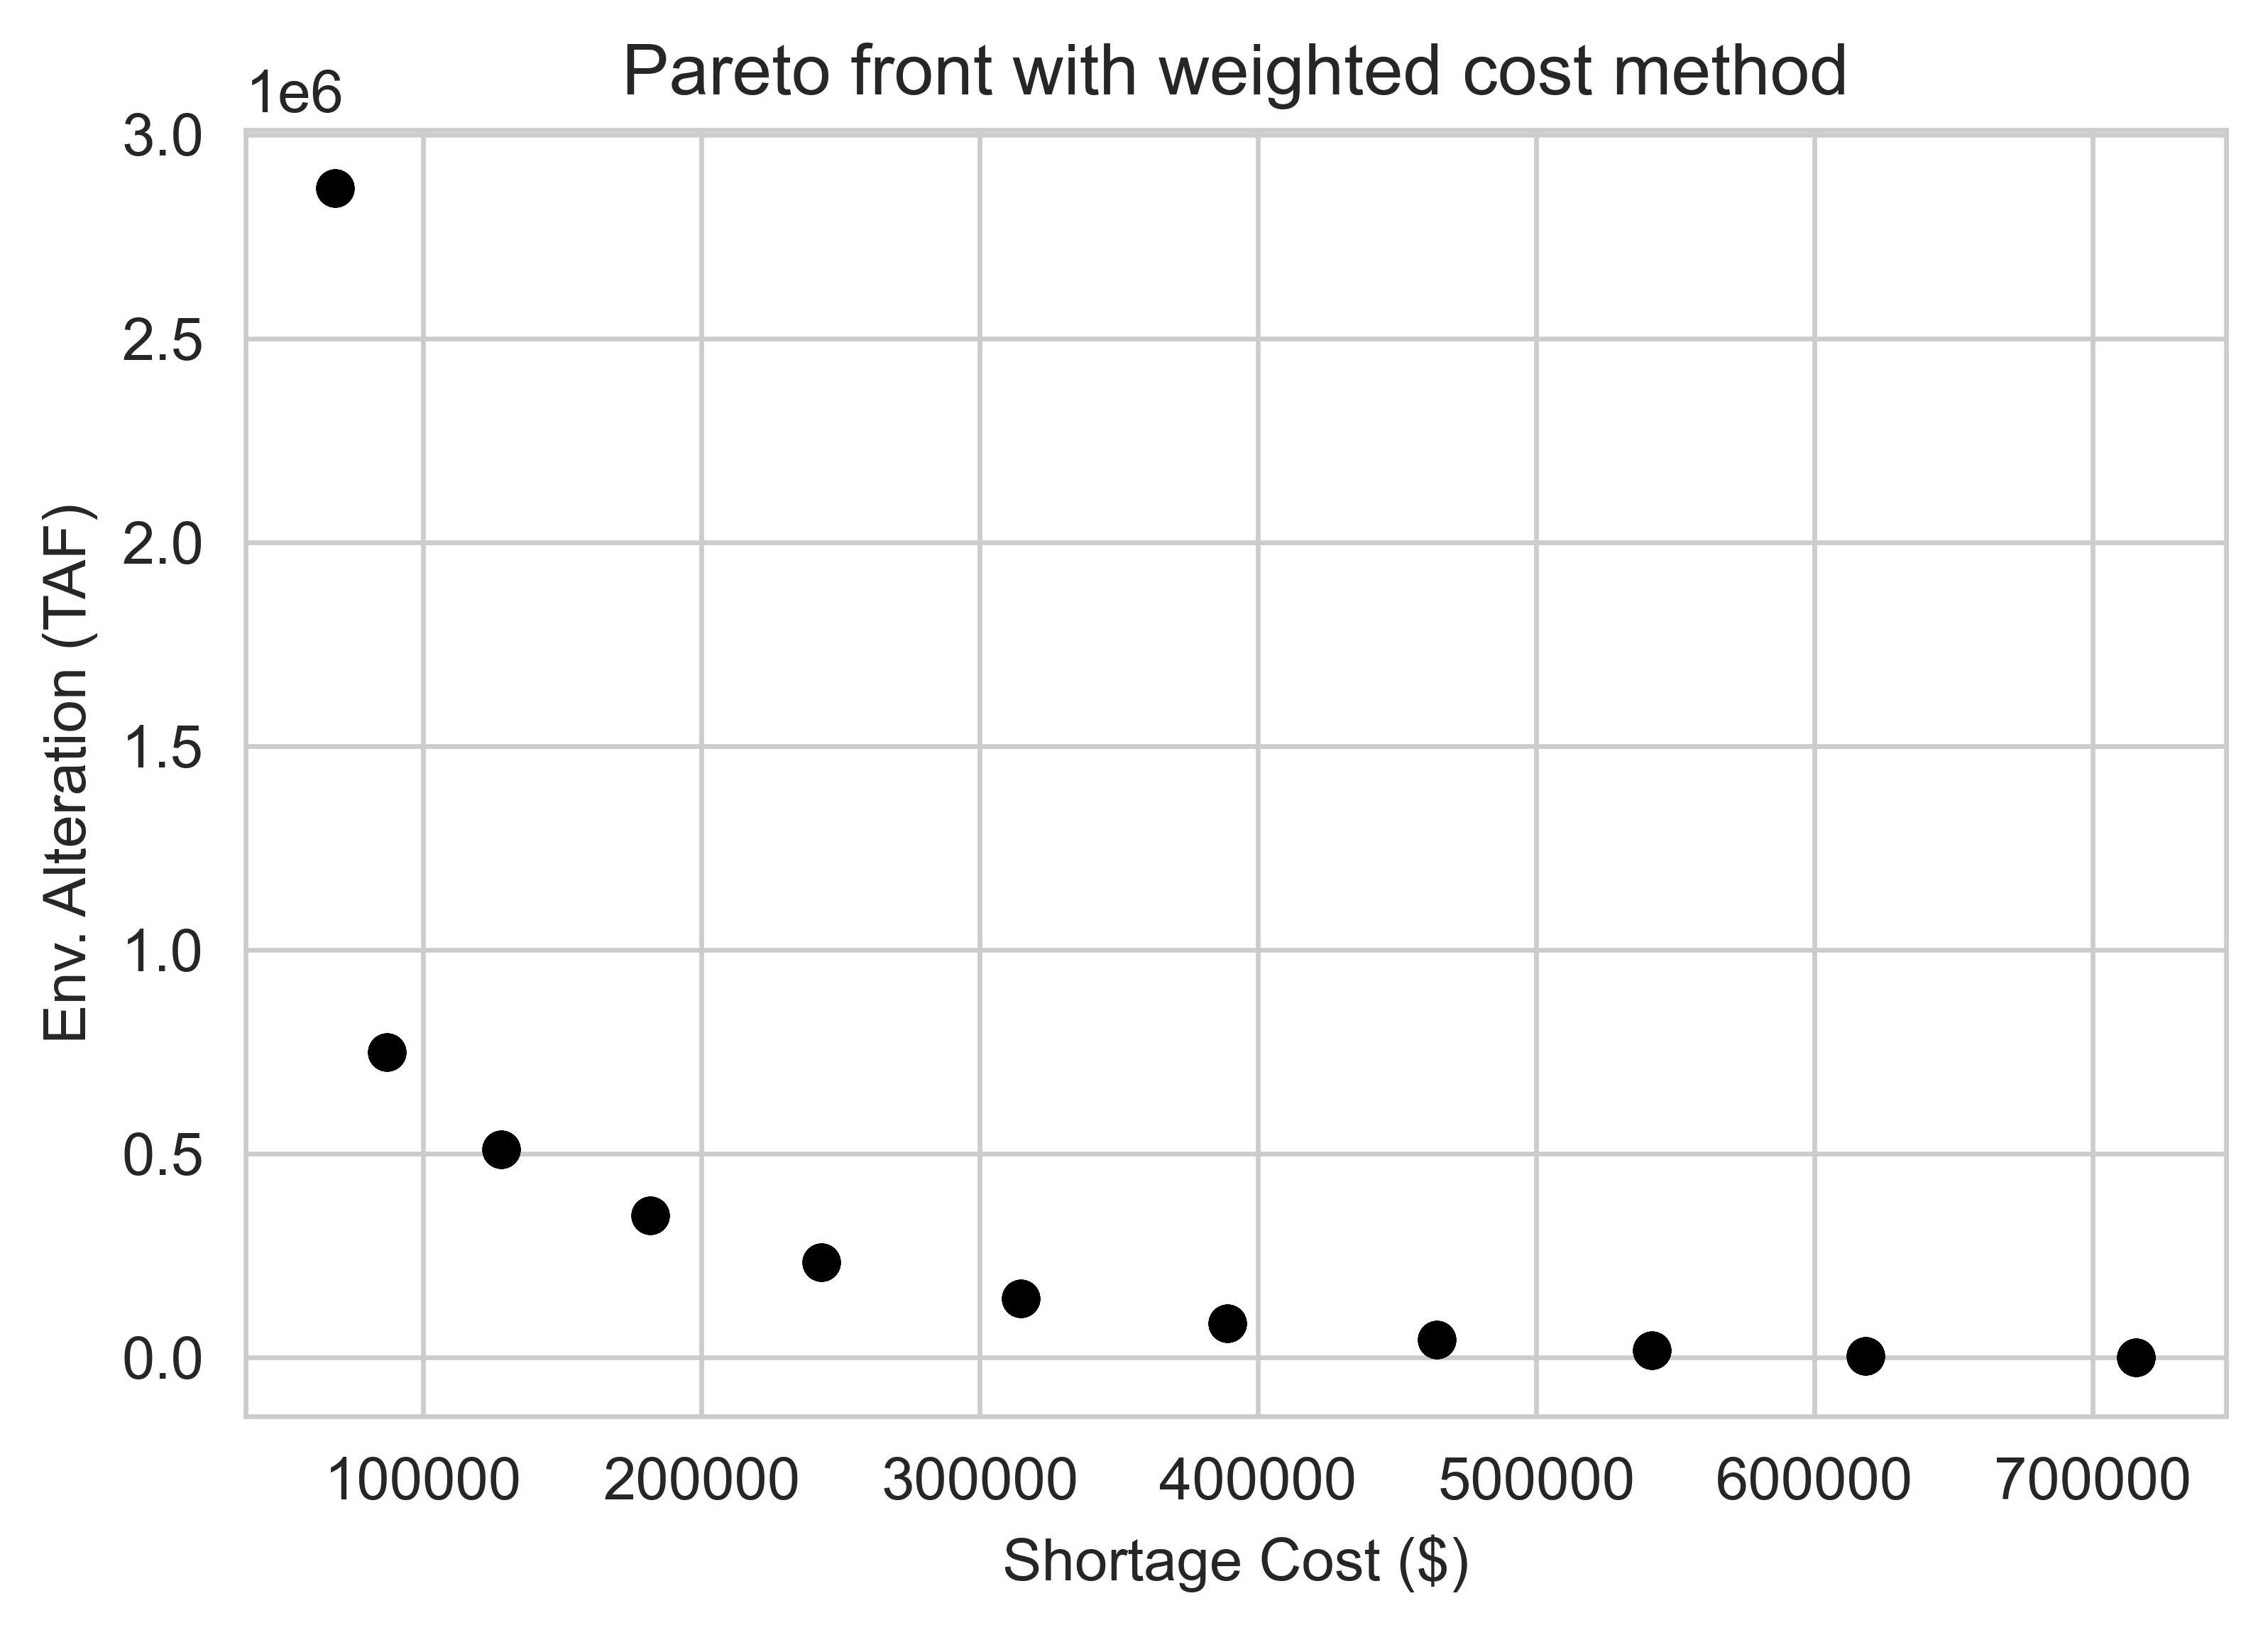

In [16]:
results = np.array(results)
plt.scatter(results[:,0],results[:,1], s=30, c='k')
plt.xlabel('Shortage Cost ($)')
plt.ylabel('Env. Alteration (TAF)')
plt.title('Pareto front with weighted cost method')
plt.show()

--------